In [247]:
import pandas as pd
import numpy as np
import psycopg2
import decimal

from sqlalchemy import create_engine

import matplotlib.pyplot as plt

import seaborn as sns

In [248]:

upper_pc_threshold = 0.04
lower_pc_threshold = 0.04

days_before_action = 4

start_date = pd.to_datetime('2010-01-01').date()
end_date = pd.to_datetime('2021-12-31').date()

ma_days =[12, 15, 18, 20 ,23 ]

# set plot size 
sns.set(rc={'figure.figsize':(18, 12)})

# show more rows
pd.set_option('display.max_rows', None)

In [249]:


POSTGRES_ADDRESS = '192.168.1.116'
POSTGRES_PORT = '5433' 
POSTGRES_USERNAME = 'root' 
POSTGRES_PASSWORD = 'password' 
POSTGRES_DBNAME = 'pystock' 

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=POSTGRES_USERNAME, 
                        password=POSTGRES_PASSWORD, 
                        ipaddress=POSTGRES_ADDRESS, 
                        port=POSTGRES_PORT, 
                        dbname=POSTGRES_DBNAME)) 
# Create the connection 
cnx = create_engine(postgres_str)
pg_prices=pd.read_sql_query('''SELECT * FROM inputs.prices WHERE ticker = 'HSBA.L' AND price_date BETWEEN '2010-01-01' AND '2022-06-01';''', cnx)
prices=pg_prices.sort_values(by=['price_date'])
prices = prices.set_index('price_date')

In [250]:

prices['volatility'] = prices['close_price'].rolling(window=10).min().shift(1) / prices['close_price'].rolling(window=10).max().shift(1)

prices['ma_days_before_action'] = prices['close_price'].rolling(window=days_before_action).max().shift(1)
prices['min_ma_days_before_action'] = prices['close_price'].rolling(window=days_before_action).min().shift(1)



#prices['rolling_mean_close'] = prices['close_price'].rolling(window=5).mean()
#for i in range(ma_weeks_min, ma_weeks_max, ma_weeks_step):
for i in ma_days:
    prices['ma_{}_upper'.format(i)] = prices['close_price'].rolling(window=i).mean().shift(1) * (1+upper_pc_threshold)
    prices['ma_{}_lower'.format(i)] = prices['close_price'].rolling(window=i).mean().shift(1) * (1-lower_pc_threshold)

#define state choices
state_choices = ['BELOW', 'ABOVE']

for i in ma_days:
#define state conditions
    state_conditions = [prices['close_price'] < prices['ma_{}_lower'.format(i)], # Close price lower than lower ma boundary
                        prices['close_price'] > prices['ma_{}_upper'.format(i)]] # Close price higher than upper ma boundary
    
    prices['state_{}'.format(i)] =  np.select(state_conditions, state_choices, default='INSIDE')
    
# define recommend choices
recommend_choices = ['BUY', 'SELL']

for i in ma_days:
#define conditions
    recommend_conditions = [ # BUY
                            (prices['state_{}'.format(i)] == 'BELOW') &  # flagged as below AND
                            (prices['close_price'] > prices['ma_days_before_action']) &  # close pride above max for action period (ignore short term upticks) AND
                            (prices['volatility'] > 0.9), # market is not too volatile (<10% drop in action period) 
                            
                            #SELL
                            (prices['state_{}'.format(i)] == 'ABOVE') & 
                            (prices['close_price'] < prices['ma_days_before_action']) & 
                            (prices['close_price'] < prices['ma_days_before_action'])]
    '''
    recommend_conditions = [(prices['state_{}'.format(i)] == 'ABOVE'),
                            (prices['state_{}'.format(i)] == 'ABOVE')]
    '''    
    prices['recommend_{}'.format(i)] =  np.select(recommend_conditions, recommend_choices, default='HOLD')

prices['min_over_max'] = prices['min_ma_days_before_action'] / prices['ma_days_before_action']
#prices.reset_index()
#prices = prices.set_index('price_date')


sample_start_date = pd.to_datetime('2011-09-01').date()
sample_end_date = pd.to_datetime('2011-11-01').date()

prices.loc[sample_start_date:sample_end_date].head(40)


ticker  high_price  low_price  open_price  close_price  \
price_date                                                           
2011-09-01  HSBA.L      542.80     532.00      540.00       538.50   
2011-09-02  HSBA.L      541.27     522.70      531.90       524.50   
2011-09-05  HSBA.L      522.00     503.70      518.50       504.50   
2011-09-06  HSBA.L      515.50     502.50      503.20       509.20   
2011-09-07  HSBA.L      526.00     514.40      518.00       525.60   
2011-09-08  HSBA.L      528.20     517.10      521.00       522.00   
2011-09-09  HSBA.L      525.80     504.50      522.80       504.50   
2011-09-12  HSBA.L      501.86     488.15      499.00       492.55   
2011-09-13  HSBA.L      502.57     484.45      500.30       499.00   
2011-09-14  HSBA.L      507.00     491.50      494.00       501.50   
2011-09-15  HSBA.L      524.80     501.06      504.60       521.10   
2011-09-16  HSBA.L      536.92     522.90      528.00       524.80   
2011-09-19  HSBA.L      518.90     506.93      513.50       511.20   
2011-09-20  HSBA.L      522.80     509.90      512.40       520.90   
2011-09-21  HSBA.L      520.00     510.25      517.80       511.90   
2011-09-22  HSBA.L      503.60     484.45      501.00       486.20   
2011-09-23  HSBA.L      498.95     484.00      496.00       498.00   
2011-09-26  HSBA.L      507.72     484.85      484.90       499.90   
2011-09-27  HSBA.L      521.45     500.00      509.10       520.40   
2011-09-28  HSBA.L      514.60     504.60      510.00       510.00   
2011-09-29  HSBA.L      517.90     503.00      506.50       512.80   
2011-09-30  HSBA.L      508.50     488.20      506.80       496.90   
2011-10-03  HSBA.L      494.46     478.15      485.15       487.60   
2011-10-04  HSBA.L      482.05     466.45      481.00       473.55   
2011-10-05  HSBA.L      489.90     473.95      484.20       485.00   
2011-10-06  HSBA.L      509.80     483.55      487.85       509.80   
2011-10-07  HSBA.L      518.20     504.60      510.00       509.00   
2011-10-10  HSBA.L      520.50     500.00      505.40       519.10   
2011-10-11  HSBA.L      520.70     508.80      517.20       519.70   
2011-10-12  HSBA.L      532.30     512.50      516.00       529.10   
2011-10-13  HSBA.L      531.89     519.50      526.00       523.10   
2011-10-14  HSBA.L      532.20     515.00      523.10       525.00   
2011-10-17  HSBA.L      532.00     518.60      526.90       523.00   
2011-10-18  HSBA.L      529.90     509.20      515.50       520.20   
2011-10-19  HSBA.L      534.49     519.80      524.90       522.50   
2011-10-20  HSBA.L      519.60     508.30      513.40       512.70   
2011-10-21  HSBA.L      520.91     512.20      516.50       518.00   
2011-10-24  HSBA.L      531.20     519.50      522.50       530.00   
2011-10-25  HSBA.L      531.70     520.00      524.10       525.00   
2011-10-26  HSBA.L      529.90     520.40      523.30       526.20   

                volume   adj_close      retrieved_date  volatility  \
price_date                                                           
2011-09-01  316.834045  15723504.0 2022-03-05 08:49:48    0.929520   
2011-09-02  308.596924  23066492.0 2022-03-05 08:49:48    0.935562   
2011-09-05  296.829712  24551317.0 2022-03-05 08:49:48    0.935562   
2011-09-06  299.595001  30866442.0 2022-03-05 08:49:48    0.935562   
2011-09-07  309.244171  18841770.0 2022-03-05 08:49:48    0.935562   
2011-09-08  307.126068  19775656.0 2022-03-05 08:49:48    0.935562   
2011-09-09  296.829712  54459696.0 2022-03-05 08:49:48    0.935562   
2011-09-12  289.798706  28737270.0 2022-03-05 08:49:48    0.935562   
2011-09-13  293.593597  21475002.0 2022-03-05 08:49:48    0.914670   
2011-09-14  295.064636  25362229.0 2022-03-05 08:49:48    0.914670   
2011-09-15  306.596405  31362174.0 2022-03-05 08:49:48    0.914670   
2011-09-16  308.773438  52781296.0 2022-03-05 08:49:48    0.937119   
2011-09-19  300.771698  21800105.0 2022-03-05 08:49:48    0.937119   
2011-09-20  306.47882

In [251]:
prices_with_investments = prices
prices_with_investments["change_cash_value"] = 0
prices_with_investments["change_share_count"] = 0
prices_with_investments["change_share_value"] = 0
prices_with_investments["running_cash_value"] = 0
prices_with_investments["running_share_count"] = 0
prices_with_investments["running_share_value"] = 0


prices_with_investments.head(2)

ticker  high_price  low_price  open_price  close_price  \
price_date                                                           
2010-01-04  HSBA.L       726.5      713.0       713.3        726.5   
2010-01-05  HSBA.L       747.2      723.0       723.0        737.0   

                volume   adj_close      retrieved_date  volatility  \
price_date                                                           
2010-01-04  401.041809  15139314.0 2022-03-05 08:49:48         NaN   
2010-01-05  406.837982  27480532.0 2022-03-05 08:49:48         NaN   

            ma_days_before_action  ...  recommend_18  recommend_20  \
price_date                         ...                               
2010-01-04                    NaN  ...          HOLD          HOLD   
2010-01-05                    NaN  ...          HOLD          HOLD   

            recommend_23  min_over_max  change_cash_value  change_share_count  \
price_date                                                                      
2010-01-04          HOLD           NaN                  0                   0   
2010-01-05          HOLD           NaN                  0                   0   

            change_share_value  running_cash_value  running_share_count  \
price_date                                                                
2010-01-04                   0                   0                    0   
2010-01-05                   0                   0                    0   

            running_share_value  
price_date                       
2010-01-04                    0  
2010-01-05                    0  

[2 rows x 38 columns]

In [252]:
def buy_units( available_funds, unit_price ):
    "returns number of units to be bought and their cost"
    bought_units = available_funds // unit_price
    bought_unit_cost = bought_units * unit_price
    return bought_units, bought_unit_cost

a, b = buy_units(1000, 51)
print(a)
print(b)


19
969


In [253]:

test_limit = 10000
i=0
activity_series = []
account_activity = pd.DataFrame(activity_series,
                               columns=['price_date', 
                                        'ticker', 
                                        'close_price', 
                                        'close_price_pc', 
                                        'ma_20_lower', 
                                        'ma_20_upper', 
                                        'recommend_20', 
                                        'ma_days_before_action',
                                        'min_ma_days_before_action',
                                        'change_cash_value',
                                        'change_share_count',
                                        'change_share_value',
                                        'running_cash_value',
                                        'running_share_count',
                                        'running_share_value',
                                        'running_account_value',
                                        'running_account_value_pc'])



recorded_running_cash_value = 10000
recorded_running_share_count = 0
recorded_running_share_value = 0
recorded_running_account_value = 0

for row_tuple in prices_with_investments.itertuples():
    if i>test_limit: break
    
    # Get first price to use as base for percentages
    if i==0: 
            base_close_price = row_tuple.close_price
            base_account_value = recorded_running_cash_value
    
    change_cash_value = 0
    change_share_count = 0 #minus sales plus purchases
    
    if row_tuple.recommend_20 == 'BUY': 
        bought_units, bought_unit_cost = buy_units(recorded_running_cash_value,
                                                   row_tuple.close_price) # this is a rather arbitary price....
        change_share_count = bought_units
        change_cash_value -= bought_unit_cost
   
    if row_tuple.recommend_20 == 'HOLD':
        change_share_value = (recorded_running_share_count * row_tuple.close_price) - recorded_running_share_value
        
    if row_tuple.recommend_20 == 'SELL': 
        sold_units = recorded_running_share_count
        sold_value = recorded_running_share_count * row_tuple.close_price # this is a rather arbitary price....
        change_share_count -= sold_units
        change_cash_value += sold_value
        change_share_value = sold_value - recorded_running_share_value

    #running_cash_value = 0
    #running_share_count = 0
    #running_share_value = 0
    #running_account_value = 0

    recorded_running_cash_value += change_cash_value
    recorded_running_share_count += change_share_count
    recorded_running_share_value = recorded_running_share_count * row_tuple.close_price
    recorded_running_account_value = recorded_running_cash_value + recorded_running_share_value
    
    
    account_activity.loc[len(account_activity.index)] = [row_tuple.Index, 
                                                          row_tuple.ticker, 
                                                          row_tuple.close_price, 
                                                          row_tuple.close_price / base_close_price, 
                                                          row_tuple.ma_20_lower, 
                                                          row_tuple.ma_20_upper, 
                                                          row_tuple.recommend_20, 
                                                          row_tuple.ma_days_before_action,
                                                          row_tuple.min_ma_days_before_action,
                                                          change_cash_value, # change_cash_value
                                                          change_share_count, # change_share_count
                                                          change_share_value, # change_share_value
                                                          recorded_running_cash_value, # running_cash_value
                                                          recorded_running_share_count, # running_share_count
                                                          recorded_running_share_value, # running_share_value
                                                          recorded_running_account_value, # running_account_value
                                                          recorded_running_account_value / base_account_value] # running_account_value_percent
    
    i+=1    
    
    '''
    account_activity = account_activity.append(pd.Series([row_tuple.price_date, 
                                                          row_tuple.ticker, 
                                                          row_tuple.close_price, 
                                                          row_tuple.ma_10_lower, 
                                                          row_tuple.ma_10_upper, 
                                                          row_tuple.recommend_10, 
                                                          change_cash_value, # change_cash_value
                                                          change_share_count, # change_share_count
                                                          change_share_value, # change_share_value
                                                          recorded_running_cash_value, # running_cash_value
                                                          recorded_running_share_count, # running_share_count
                                                          recorded_running_share_value, # running_share_value
                                                          recorded_running_account_value], # running_account_value
                        index=account_activity.columns),
                        ignore_index=True)
    

    
    i+=1
pd.set_option("max_rows", None)
account_activity

'''
    
account_activity = account_activity.set_index('price_date')
account_activity.head(1)
#account_activity.dtypes

ticker  close_price  close_price_pc  ma_20_lower  ma_20_upper  \
price_date                                                                  
2010-01-04  HSBA.L        726.5             1.0          NaN          NaN   

           recommend_20  ma_days_before_action  min_ma_days_before_action  \
price_date                                                                  
2010-01-04         HOLD                    NaN                        NaN   

            change_cash_value  change_share_count  change_share_value  \
price_date                                                              
2010-01-04                0.0                 0.0                 0.0   

            running_cash_value  running_share_count  running_share_value  \
price_date                                                                 
2010-01-04             10000.0                  0.0                  0.0   

            running_account_value  running_account_value_pc  
price_date                                                   
2010-01-04                10000.0                       1.0

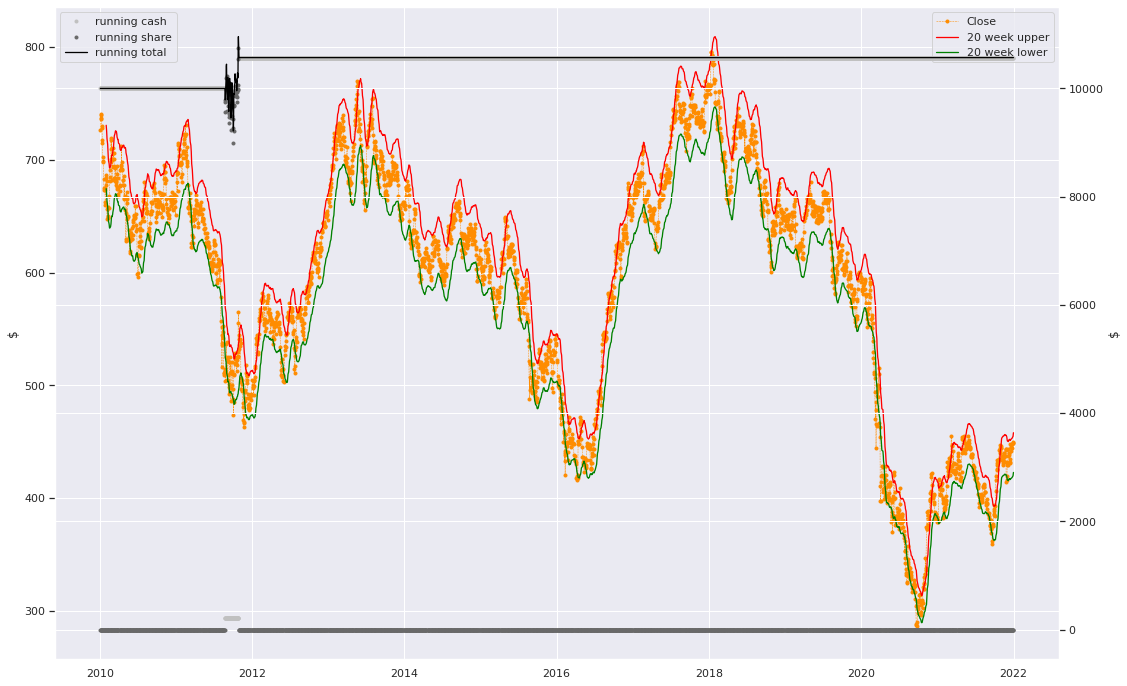

In [254]:
## ADM bugger about with graphing. From: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

# Start and end of the date range to extract
# Plot daily and weekly resampled time series together
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#start_date = pd.to_datetime('2013-01-01').date()
#end_date = pd.to_datetime('2013-07-01').date()

#ax1.set_ylim([450,600])
#ax2.set_ylim([6000,12000])
ax1.plot(account_activity.loc[start_date:end_date, 'close_price'],
marker='.', linestyle='--', linewidth=0.5, label='Close', color='darkorange')
#ax1.plot(account_activity.loc[start_date:end_date, 'close_price_pc'],
#marker='.', linestyle='--', linewidth=0.5, label='Close %', color='darkorange')
#ax1.plot(account_activity.loc[start_date:end_date, 'running_account_value_pc'],
#marker='.', linestyle='--', linewidth=0.5, label='Cash', color='red')
#ax.plot(graph_prices.loc[start_date:end_date, 'ma_10_upper'],
#marker='', linestyle='-', linewidth=1, label='10 week upper')
#ax.plot(graph_prices.loc[start_date:end_date, 'ma_10_lower'],
#marker='', linestyle='-', linewidth=1, label='10 week lower')
ax1.plot(account_activity.loc[start_date:end_date, 'ma_20_upper'],
marker='', linestyle='-', linewidth=1.3, label='20 week upper', color='red')
ax1.plot(account_activity.loc[start_date:end_date, 'ma_20_lower'],
marker='', linestyle='-', linewidth=1.3, label='20 week lower', color='green')

ax2.plot(account_activity.loc[start_date:end_date, 'running_cash_value'],
marker='.', linestyle='-', linewidth=0, label='running cash', color='silver')
ax2.plot(account_activity.loc[start_date:end_date, 'running_share_value'],
marker='.', linestyle='-', linewidth=0, label='running share', color='dimgray')
ax2.plot(account_activity.loc[start_date:end_date, 'running_account_value'],
marker='', linestyle='-', linewidth=1.3, label='running total', color='black')

ax1.set_ylabel('$')
ax2.set_ylabel('$')
ax1.legend();
ax2.legend();

In [255]:
account_activity.head()

ticker  close_price  close_price_pc  ma_20_lower  ma_20_upper  \
price_date                                                                  
2010-01-04  HSBA.L        726.5        1.000000          NaN          NaN   
2010-01-05  HSBA.L        737.0        1.014453          NaN          NaN   
2010-01-06  HSBA.L        740.4        1.019133          NaN          NaN   
2010-01-07  HSBA.L        736.5        1.013765          NaN          NaN   
2010-01-08  HSBA.L        740.0        1.018582          NaN          NaN   

           recommend_20  ma_days_before_action  min_ma_days_before_action  \
price_date                                                                  
2010-01-04         HOLD                    NaN                        NaN   
2010-01-05         HOLD                    NaN                        NaN   
2010-01-06         HOLD                    NaN                        NaN   
2010-01-07         HOLD                    NaN                        NaN   
2010-01-08         HOLD                  740.4                      726.5   

            change_cash_value  change_share_count  change_share_value  \
price_date                                                              
2010-01-04                0.0                 0.0                 0.0   
2010-01-05                0.0                 0.0                 0.0   
2010-01-06                0.0                 0.0                 0.0   
2010-01-07                0.0                 0.0                 0.0   
2010-01-08                0.0                 0.0                 0.0   

            running_cash_value  running_share_count  running_share_value  \
price_date                                                                 
2010-01-04             10000.0                  0.0                  0.0   
2010-01-05             10000.0                  0.0                  0.0   
2010-01-06             10000.0                  0.0                  0.0   
2010-01-07             10000.0                  0.0                  0.0   
2010-01-08             10000.0                  0.0                  0.0   

            running_account_value  running_account_value_pc  
price_date                                                   
2010-01-04                10000.0                       1.0  
2010-01-05                10000.0                       1.0  
2010-01-06                10000.0                       1.0  
2010-01-07                10000.0                       1.0  
2010-01-08                10000.0                       1.0

ticker  close_price  close_price_pc  ma_20_lower  ma_20_upper  \
price_date                                                                  
2016-01-04  HSBA.L        520.4        1.000000     503.4984     545.4566   
2016-01-05  HSBA.L        522.6        1.004228     502.5336     544.4114   
2016-01-06  HSBA.L        508.3        0.976749     502.3128     544.1722   
2016-01-07  HSBA.L        502.0        0.964643     501.5928     543.3922   

            ma_days_before_action  min_ma_days_before_action  close_price_pc  \
price_date                                                                     
2016-01-04                  544.6                      536.2        1.000000   
2016-01-05                  544.6                      520.4        1.004228   
2016-01-06                  537.8                      520.4        0.976749   
2016-01-07                  536.2                      508.3        0.964643   

            running_account_value  running_account_value_pc  \
price_date                                                    
2016-01-04                10570.0                       1.0   
2016-01-05                10570.0                       1.0   
2016-01-06                10570.0                       1.0   
2016-01-07                10570.0                       1.0   

            ma_days_before_action_pc  min_ma_days_before_action_pc  \
price_date                                                           
2016-01-04                  1.000000                      1.000000   
2016-01-05                  1.000000                      0.970533   
2016-01-06                  0.987514                      0.970533   
2016-01-07                  0.984576                      0.947967   

            ma_20_lower_pc  ma_20_upper_pc  
price_date                                  
2016-01-04        0.960000        1.040000  
2016-01-05        0.958160        1.038007  
2016-01-06        0.957739        1.037551  
2016-01-07        0.956367        1.036064

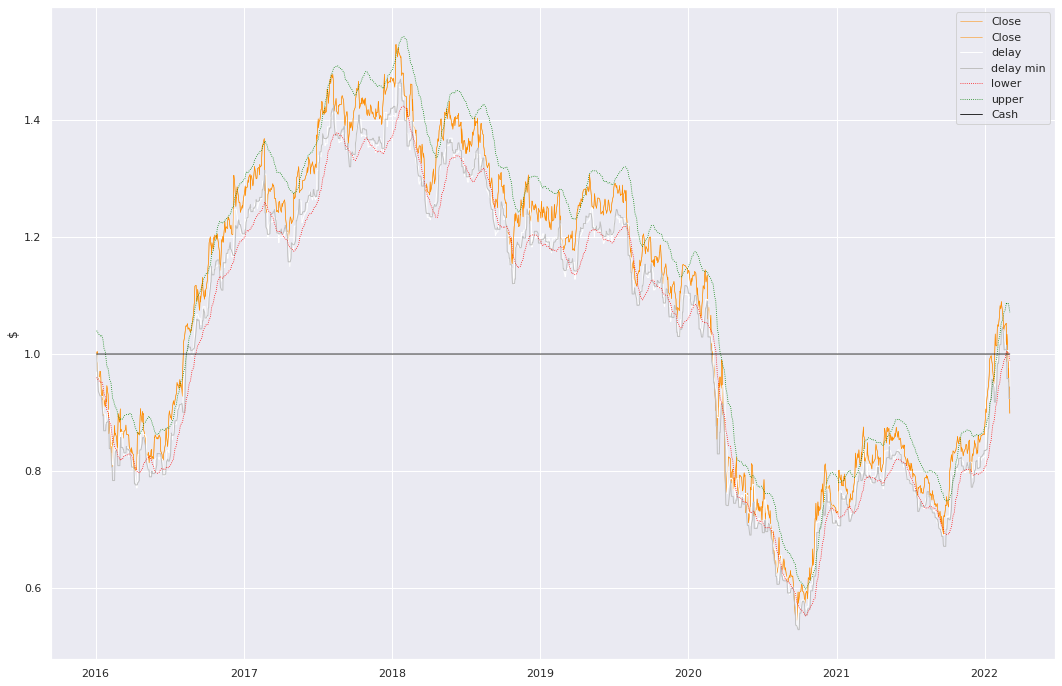

In [256]:
## ADM bugger about with graphing. From: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/


start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2026-12-01').date()

graph_activity = account_activity.loc[start_date:end_date][['ticker',
                                                            'close_price', 
                                                            'close_price_pc', 
                                                            'ma_20_lower', 
                                                            'ma_20_upper', 
                                                            'ma_days_before_action',
                                                            'min_ma_days_before_action',
                                                            'close_price_pc', 
                                                            'running_account_value', 
                                                            'running_account_value_pc']].copy(deep=True)

base_close_price = graph_activity.loc[graph_activity.index[0]].close_price
base_ma_20 = graph_activity.loc[graph_activity.index[0]].ma_20_upper / (1 + upper_pc_threshold)
base_account_value = graph_activity.loc[graph_activity.index[0]].running_account_value
base_ma_days_before_action = graph_activity.loc[graph_activity.index[0]].ma_days_before_action
base_min_ma_days_before_action = graph_activity.loc[graph_activity.index[0]].min_ma_days_before_action

graph_activity['ma_days_before_action_pc'] = graph_activity['ma_days_before_action'] / base_ma_days_before_action
graph_activity['min_ma_days_before_action_pc'] = graph_activity['min_ma_days_before_action'] / base_min_ma_days_before_action
graph_activity['close_price_pc'] = graph_activity['close_price'] / base_close_price
graph_activity['ma_20_lower_pc'] = graph_activity['ma_20_lower'] / base_ma_20
graph_activity['ma_20_upper_pc'] = graph_activity['ma_20_upper'] / base_ma_20
graph_activity['running_account_value_pc'] = graph_activity['running_account_value'] / base_account_value

# Start and end of the date range to extract
# Plot daily and weekly resampled time series together
fig, ax1 = plt.subplots()
ax1.plot(graph_activity.loc[start_date:end_date, 'close_price_pc'],
marker='', linestyle='-', linewidth=0.5, label='Close', color='darkorange')
ax1.plot(graph_activity.loc[start_date:end_date, 'ma_days_before_action_pc'],
marker='', linestyle='-', linewidth=1, label='delay', color='white')
ax1.plot(graph_activity.loc[start_date:end_date, 'min_ma_days_before_action_pc'],
marker='', linestyle='-', linewidth=1, label='delay min', color='silver')
ax1.plot(graph_activity.loc[start_date:end_date, 'ma_20_lower_pc'],
marker='', linestyle=':', linewidth=0.8, label='lower', color='red')
ax1.plot(graph_activity.loc[start_date:end_date, 'ma_20_upper_pc'],
marker='', linestyle=':', linewidth=0.8, label='upper', color='green')
ax1.plot(graph_activity.loc[start_date:end_date, 'running_account_value_pc'],
marker='', linestyle='-', linewidth=0.8, label='Cash', color='black')

ax1.set_ylabel('$')
ax1.legend();
pd.set_option('display.max_rows', None)
graph_activity.head(4)


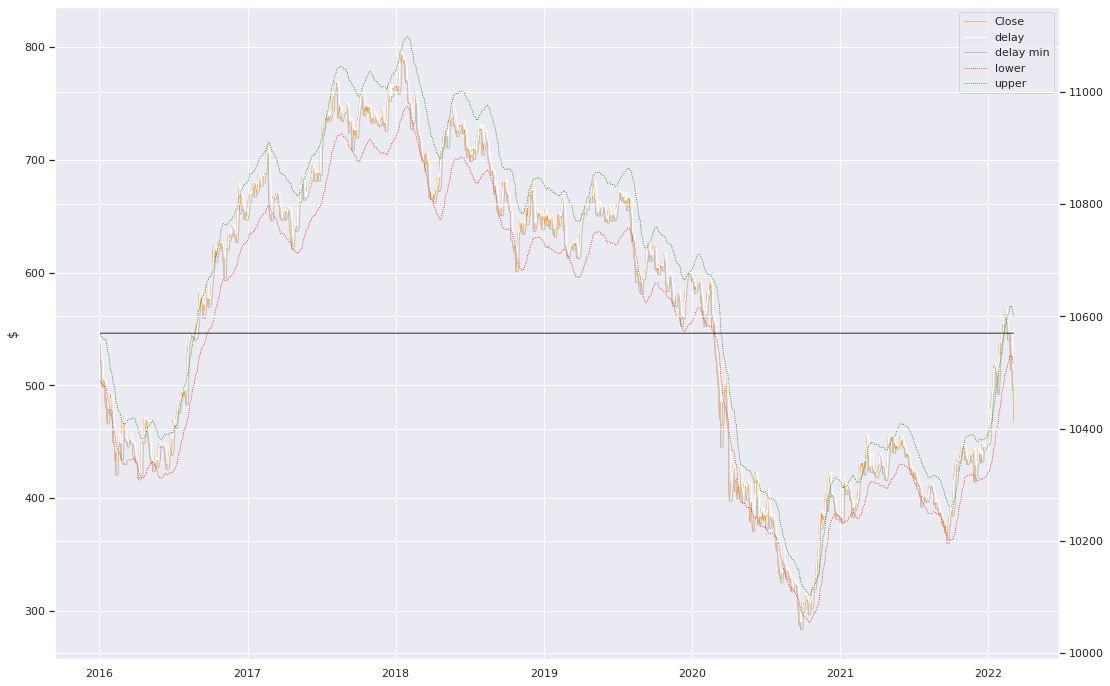

In [257]:
# Start and end of the date range to extract
# Plot daily and weekly resampled time series together
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(graph_activity.loc[start_date:end_date, 'close_price'],
marker='', linestyle='-', linewidth=0.5, label='Close', color='darkorange')
ax1.plot(graph_activity.loc[start_date:end_date, 'ma_days_before_action'],
marker='', linestyle='-', linewidth=1, label='delay', color='white')
ax1.plot(graph_activity.loc[start_date:end_date, 'min_ma_days_before_action'],
marker='', linestyle='-', linewidth=1, label='delay min', color='silver')
ax1.plot(graph_activity.loc[start_date:end_date, 'ma_20_lower'],
marker='', linestyle=':', linewidth=0.8, label='lower', color='red')
ax1.plot(graph_activity.loc[start_date:end_date, 'ma_20_upper'],
marker='', linestyle=':', linewidth=0.8, label='upper', color='green')
ax2.plot(graph_activity.loc[start_date:end_date, 'running_account_value'],
marker='', linestyle='-', linewidth=0.8, label='Cash', color='black')

ax1.set_ylabel('$')
ax1.legend();

